In [1]:
import gzip

import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def load_log(filename):
    """Load data from logs generated from limtoc. Returns
    a numpy record array.
    """
    datatype = None
    values = []
    
    if filename.endswith('.gz'):
        openf = lambda x: gzip.open(x, 'rt')
    else:
        openf = open
    
    with openf(filename) as f:
        for line in f:
            if not line.strip():
                continue
            if datatype is None:
                if line.strip().endswith('fields are:'):
                    # ignore lines until we get here
                    # next line describes data
                    datatype = []
                elif 'k = ' in line:
                    print(line.strip())
                continue
            if not datatype:
                field_names = line.split(',')
                datatype = np.dtype(
                    [('time', '<f8')] + [(name.strip(), '<f8') for name in field_names])
            else:
                vals = [float(f) for f in line.split(',')]
                assert len(vals) == len(datatype) - 1
                vals.insert(0, vals[0]) # copy clock field value to time
                values.append(tuple(vals))
                
    data = np.rec.array(values, dtype=datatype)
    t = data.time
    dt = np.diff(t)
    overflow_counts = 2**32 * np.cumsum(dt < 0)
    data.time[1:] += overflow_counts
    data.time -= data.time[0]
    data.time /= 168e6 # real time clock frequency
    return data

In [3]:
def plot_log(record, show_plot=True):
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    
    ax[0].plot(record.time, record.steer_angle, color=colors[1], label='steer angle')
    ax[0].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('[rad]')
    
    ax[1].plot(record.time, record.kistler_torque, color=colors[3],
               alpha=0.8, label='sensor torque')
    ax[1].plot(record.time, record.motor_torque, color=colors[5],
               alpha=0.8, label='motor torque')
    ax[1].plot(record.time, record.feedback_torque, color=colors[7],
               alpha=0.8, label='feedback torque command')
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('torque [N-m]')
    ax[1].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    if show_plot:
        plt.show()
    return fig, ax

In [4]:
def display_log_plot(filename):
    vals = load_log(filename)
    fig, ax = plot_log(vals, show_plot=False)
    try:
        title = filename
        mpld3
    except NameError:
        fig.suptitle(title)
    else:
        ax[0].set_title(title)
    plt.show()

running limtoc 626a9c2, k =    3.140


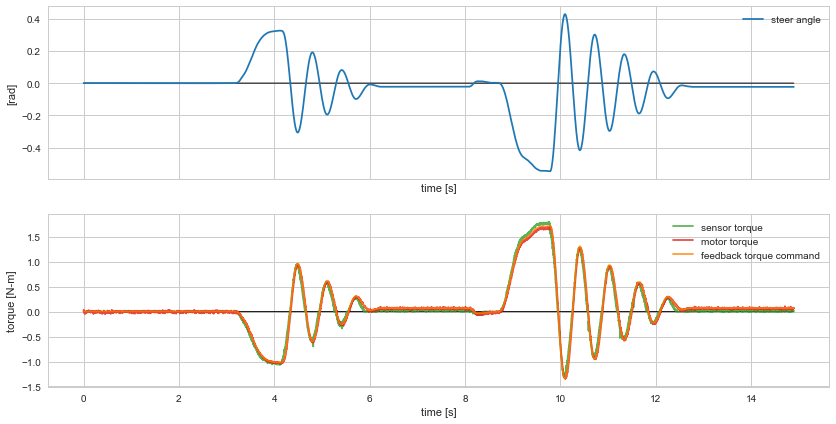

(<matplotlib.figure.Figure at 0x114007630>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1140b3710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1140df518>], dtype=object))

In [5]:
data = load_log('torque_oscillation.log.gz')
plot_log(data)

In [6]:
import sympy
from sympy import pi, sqrt, symbols
from IPython.display import display, Math
from sympy.physics.vector import vlatex

def print_eq(a, b):
    display(Math(vlatex(a) + ' = ' + vlatex(b)))

In [7]:
def plot_fft(record):
    N = len(record)
    dt = np.diff(record.time).mean()
    xf = scipy.fftpack.fftfreq(N, dt)
    yf = scipy.fftpack.fft(record.steer_angle)
    
    # plot only frequency components less than 10 Hz
    fftslice = slice(0, np.where(xf > 10)[0][0])
    
    fig, ax = plt.subplots()
    ax.plot(xf[fftslice], 2/N * np.abs(yf[fftslice]))
    plt.show()
    return fig, ax

In [8]:
# motor torque = -k * x
def calculate_stiffness(record):
    k_commanded = np.linalg.lstsq(np.reshape(record.steer_angle, (-1, 1)),
                                  -np.reshape(record.feedback_torque, (-1, 1)))[0][0][0]
    k_measured = np.linalg.lstsq(np.reshape(record.steer_angle, (-1, 1)),
                                 -np.reshape(record.motor_torque, (-1, 1)))[0][0][0]
    return k_commanded, k_measured

In [9]:
def calculate_fit(record):
    # use equation of the form:
    #   x = (a + bt)*exp(c*t)*sin(2*pi*e*t + d)
    fit = []
    
    n = 'exponential'
    f = lambda a, b, c, d, e: lambda t: a*np.exp(c*t)*np.sin(2*np.pi*e*t + d)
    p0 = (0, 0, -0.1, 0, 1.5)
    fit.append([n, f, p0])
    
    n = 'linear'
    f = lambda a, b, c, d, e: lambda t: (a + b*t)*np.sin(2*np.pi*e*t + d)
    p0 = (0, -2, 0, 0, 1.5)
    fit.append([n, f, p0])
    
    g = lambda record, f: lambda p: f(*p)(record.time) - record.steer_angle
    
    for i in range(len(fit)):
        n, f, p0 = fit[i]
        p = scipy.optimize.leastsq(g(record, f), p0)[0]
        fit[i][2] = p
    return fit

In [10]:
def plot_fit(record, fit_params, show_plot=True):
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(len(fit_params), 1, figsize=(12, 8), sharex=True)
    
    for i in range(len(fit_params)):
        n, f, p = fit[i]
        ax[i].plot(record.time, record.steer_angle, color=colors[1],
                   label='steer angle')
        ax[i].plot(record.time, f(*p)(record.time), color=colors[5],
                   linestyle='--',
                   label='{} decay fit, {}'.format(n, p))
        ax[i].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
        ax[i].legend()
        ax[i].set_ylabel('[rad]')
    ax[-1].set_xlabel('time [s]')
    plt.show()
    return fig, ax

x = (a + bt)*exp(c*t)*sin(2*pi*e*t + d)


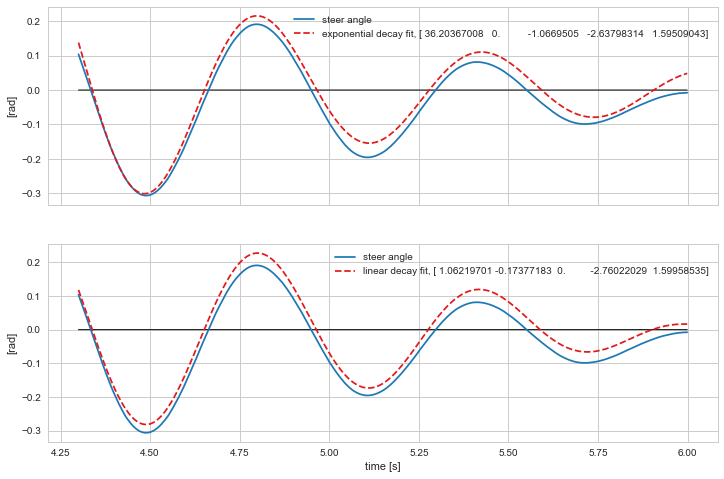

desired stiffness is 3.1400629194771628 N-m/rad
measured stiffness is 3.0747205736119034 N-m/rad

moment of inertia is 0.03043904895357336 kg-m^2

assuming coulomb friction dominates
friction torque is 0.08350598823024578 N-m


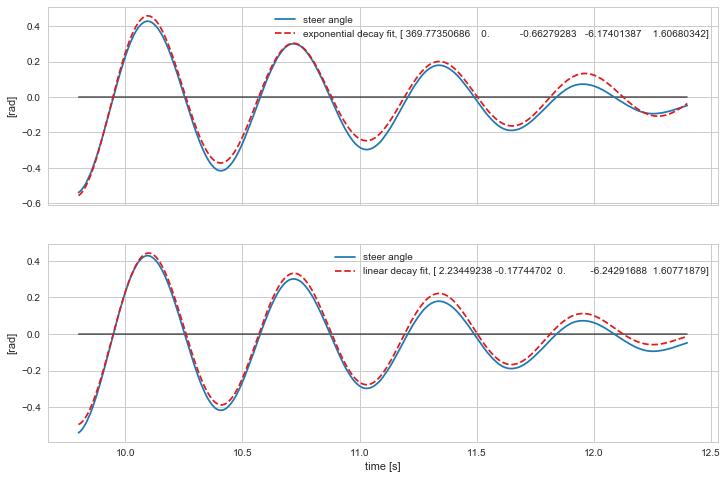

desired stiffness is 3.140041054924147 N-m/rad
measured stiffness is 3.1182677963264136 N-m/rad

moment of inertia is 0.03055860294178925 kg-m^2

assuming coulomb friction dominates
friction torque is 0.08604230636341675 N-m


In [11]:
print('x = (a + bt)*exp(c*t)*sin(2*pi*e*t + d)')

# use subset of data when oscillating
d1 = data[4300:6000]
d2 = data[9800:12400]
for di in [d1, d2]:
    #fig, ax = plot_fft(di)
    fit = calculate_fit(di)
    fig, ax = plot_fit(di, fit)
    a, b, c, d, e = fit[1][2]
    
    k_c, k_m = calculate_stiffness(di)
    print('desired stiffness is {} N-m/rad'.format(k_c))
    print('measured stiffness is {} N-m/rad'.format(k_m))
    
    # I = k / (2*pi*f_n)^2
    I = k_m/(2*np.pi*e)**2
    print('')
    print('moment of inertia is {} kg-m^2'.format(I))
    
    print('')
    print('assuming coulomb friction dominates')
    # b = ±2*F_d*2*pi*f_n/(pi*k)
    print('friction torque is {} N-m'.format(np.abs(b * k_m/(4*e))))